# Loan Data from Prosper
#### by Suelen Fenali

## Preliminary Wrangling

The data used for this analysis contains around 114k loans with 81 variables, and it's provided by [Prosper](https://www.prosper.com). I will choose around 10-15 variables to visualise univariate, bivariate and multivariate plots, in order to get insights from this data. A slide deck is provided with the explanatory analysis.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline

# make pandas display all columns and lines without '...'
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

### Gather

In [2]:
loan_raw = pd.read_csv('prosperLoanData.csv')
dictionary = pd.read_csv('dictionary.csv')

In [3]:
loan_raw.shape

(113937, 81)

In [4]:
dictionary.head(3)

,variable,description
0,ListingKey,"Unique key for each listing, same value as the..."
1,ListingNumber,The number that uniquely identifies the listin...
2,ListingCreationDate,The date the listing was created.


In [5]:
loan_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
ListingKey                             113937 non-null object
ListingNumber                          113937 non-null int64
ListingCreationDate                    113937 non-null object
CreditGrade                            28953 non-null object
Term                                   113937 non-null int64
LoanStatus                             113937 non-null object
ClosedDate                             55089 non-null object
BorrowerAPR                            113912 non-null float64
BorrowerRate                           113937 non-null float64
LenderYield                            113937 non-null float64
EstimatedEffectiveYield                84853 non-null float64
EstimatedLoss                          84853 non-null float64
EstimatedReturn                        84853 non-null float64
ProsperRating (numeric)                84853 non-null float64
ProsperRating (Alpha) 

### What is the structure of the dataset?

The dataset has 113937 registries and 81 columns. The information is composed of the listing details, the loan situation, amount, interest rates, borrowers profile (employment status, occupation, delinquencies), lenders investiment and yields. Some columns have data from before July 2009, and other the data after that. Some features are present only before July 2009.

In order to narrow this analysis, I will not use the 81 features. I went through the [dictionary](https://docs.google.com/spreadsheets/d/1gDyi_L4UvIrLTEC6Wri5nbaMmkGmLQBk-Yx3z0XDEtI/edit#gid=0) provided for this data and chose 18 variables to focus on them, I also selected the dates, keys ans status to understand the registries. Below, I will provide them with their respective description.


In [6]:
loan_data = loan_raw[['Term', 'BorrowerAPR', 'BorrowerRate',
                      'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn',
                      'ProsperRating (Alpha)', 'ProsperScore', 'ListingCategory (numeric)', 'Occupation',
                      'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner',
                      'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'LoanOriginalAmount',
                      'ListingKey', 'ListingNumber', 'LoanKey', 'LoanNumber', 'LoanStatus',
                      'ListingCreationDate', 'LoanOriginationDate', 'DateCreditPulled', 'ClosedDate']]

In [7]:
for c in loan_data.columns:
    print(f'{c}: {dictionary[dictionary.variable == c].description.values[0]} \n ***\n')

Term: The length of the loan expressed in months. 
 ***

BorrowerAPR: The Borrower's Annual Percentage Rate (APR) for the loan. 
 ***

BorrowerRate: The Borrower's interest rate for this loan.  
 ***

LenderYield: The Lender yield on the loan. Lender yield is equal to the interest rate on the loan less the servicing fee. 
 ***

EstimatedEffectiveYield: Effective yield is equal to the borrower interest rate (i) minus the servicing fee rate, (ii) minus estimated uncollected interest on charge-offs, (iii) plus estimated collected late fees.  Applicable for loans originated after July 2009. 
 ***

EstimatedLoss: Estimated loss is the estimated principal loss on charge-offs. Applicable for loans originated after July 2009. 
 ***

EstimatedReturn: The estimated return assigned to the listing at the time it was created. Estimated return is the difference between the Estimated Effective Yield and the Estimated Loss Rate. Applicable for loans originated after July 2009. 
 ***

ProsperRating (Al

### What are the main features of interest in the dataset?

Prosper provides the borrower interest rate, the estimated return and other key metrics about the loan that is being asked. The main features of interest in this dataset are Prosper calculated rates:
* BorrowerAPR
* BorrowerRate
* EstimatedReturn
* EstimatedEffectiveYield
* EstimatedLoss
* LenderYield

I would like to understand which are the caracteristics of the borrower and the listing that are related to this calculated values.

### ...and what features in the dataset will help to support the investigation into my features of interest?
The borrower profile that is composed of:
* Occupation
* EmploymentStatus
* EmploymentStatusDuration
* IsBorrowerHomeowner
* CurrentDelinquencies
* AmountDelinquent
* DelinquenciesLast7Years

The listing profile that is composed of:
* ListingCategory
* ProsperRating
* Term
* LoanStatus
* ProsperScore
* LoanOriginalAmount

### Quick Assess

In [8]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 27 columns):
Term                         113937 non-null int64
BorrowerAPR                  113912 non-null float64
BorrowerRate                 113937 non-null float64
LenderYield                  113937 non-null float64
EstimatedEffectiveYield      84853 non-null float64
EstimatedLoss                84853 non-null float64
EstimatedReturn              84853 non-null float64
ProsperRating (Alpha)        84853 non-null object
ProsperScore                 84853 non-null float64
ListingCategory (numeric)    113937 non-null int64
Occupation                   110349 non-null object
EmploymentStatus             111682 non-null object
EmploymentStatusDuration     106312 non-null float64
IsBorrowerHomeowner          113937 non-null bool
CurrentDelinquencies         113240 non-null float64
AmountDelinquent             106315 non-null float64
DelinquenciesLast7Years      112947 non-null float64
Loa

In [9]:
loan_data.Term.value_counts()

36    87778
60    24545
12     1614
Name: Term, dtype: int64

In [10]:
loan_data.LoanStatus.value_counts()

Current                   56576
Completed                 38074
Chargedoff                11992
Defaulted                  5018
Past Due (1-15 days)        806
Past Due (31-60 days)       363
Past Due (61-90 days)       313
Past Due (91-120 days)      304
Past Due (16-30 days)       265
FinalPaymentInProgress      205
Past Due (>120 days)         16
Cancelled                     5
Name: LoanStatus, dtype: int64

In [11]:
loan_data['ProsperRating (Alpha)'].value_counts()

C     18345
B     15581
A     14551
D     14274
E      9795
HR     6935
AA     5372
Name: ProsperRating (Alpha), dtype: int64

In [12]:
loan_data.ProsperScore.unique()

array([nan,  7.,  9.,  4., 10.,  2., 11.,  8.,  5.,  3.,  6.,  1.])

In [13]:
loan_data[loan_data['ProsperScore'] == 11]['ProsperRating (Alpha)'].value_counts()

AA    739
A     521
B     171
C      25
Name: ProsperRating (Alpha), dtype: int64

In [14]:
loan_data.ListingKey.value_counts().head()

17A93590655669644DB4C06    6
8474358854651984137201C    4
DE8535960513435199406CE    4
349D3587495831350F0F648    4
47C1359638497431975670B    4
Name: ListingKey, dtype: int64

There are duplicated listings. I will check the dates to understand if there is any information different.

In [15]:
dup = loan_data[loan_data.duplicated(subset=['ListingKey']) == True].ListingKey.values
df_dup = loan_data.query(f"ListingKey in {list(dup)[:5]}")

df_dup.sort_values('ListingKey')[['ListingKey', 'ListingNumber', 'LoanKey', 'LoanNumber',
                                  'ProsperScore', 'ListingCreationDate',
                                  'LoanOriginationDate', 'DateCreditPulled', 'ClosedDate']]

,ListingKey,ListingNumber,LoanKey,LoanNumber,ProsperScore,ListingCreationDate,LoanOriginationDate,DateCreditPulled,ClosedDate
998,0A0635972629771021E38F3,1055932,CB643706582969191E8C26B,132043,6.0,2013-12-18 14:25:17.053000000,2014-02-12 00:00:00,2014-02-08 11:39:13,NaN
999,0A0635972629771021E38F3,1055932,CB643706582969191E8C26B,132043,7.0,2013-12-18 14:25:17.053000000,2014-02-12 00:00:00,2014-02-08 11:39:13,NaN
57494,0A0635972629771021E38F3,1055932,CB643706582969191E8C26B,132043,8.0,2013-12-18 14:25:17.053000000,2014-02-12 00:00:00,2014-02-08 11:39:13,NaN
8,0F043596202561788EA13D5,1023355,02163700809231365A56A1C,121268,9.0,2013-12-02 10:43:39.117000000,2013-12-12 00:00:00,2013-12-02 10:43:39,NaN
9,0F043596202561788EA13D5,1023355,02163700809231365A56A1C,121268,11.0,2013-12-02 10:43:39.117000000,2013-12-12 00:00:00,2013-12-02 10:43:39,NaN
1554,2D2635984503681189056B4,1097584,DC303708663304668E74587,135375,9.0,2014-01-11 07:50:08.037000000,2014-03-11 00:00:00,2014-03-07 10:04:00,NaN
2539,2D2635984503681189056B4,1097584,DC303708663304668E74587,135375,10.0,2014-01-11 07:50:08.037000000,2014-03-11 00:00:00,2014-03-07 10:04:00,NaN
1803,4B7E3590031274113F1FD34,927246,8D84369399064302947D8B5,103928,3.0,2013-09-26 09:35:36.317000000,2013-10-01 00:00:00,2013-09-26 09:35:36,NaN
4942,4B7E3590031274113F1FD34,927246,8D84369399064302947D8B5,103928,2.0,2013-09-26 09:35:36.317000000,2013-10-01 00:00:00,2013-09-26 09:35:36,NaN
5811,94B035909835592957503E6,920397,129C369881799628360C904,110525,3.0,2013-09-24 13:27:48.287000000,2013-11-14 00:00:00,2013-10-30 17:36:21,NaN


#### Documentation
- The columns `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn`, `ProsperRating (Alpha)`, `ProsperScore` have data available just after 2009, as they are key indicators to this analysis, I will delete the data from previous years.
- There are duplicated registries with the same dates and keys, but different ProsperScore.
- The following columns have missing values: `Occupation`, `EmploymentStatus`, `EmploymentStatusDuration`, `CurrentDelinquencies`, `AmountDelinquent`, `DelinquenciesLast7Years`.
- ListingCategory is the numeric representation for categories. It can be changed to have more semantic values.
- Term is a category, in which 12 = 12 months; 36 = 36 months and 60 = 60 months.
- The columnns `ProsperRating (alpha)` and `ListingCategory (numeric)` have names not acessible by `df.column_name`.
- DelinquenciesLast7Years has wrong data type.
- ProsperScore is from 1-10, but there are values = 11.
- LoanStatus of `Past Due(>120 days)` is equal to `Chargedoff` according to [Prosper website](https://prosper.zendesk.com/hc/en-us/articles/208500186-How-can-I-review-the-status-of-a-late-loan-)

### Clean

*The columns EstimatedEffectiveYield, EstimatedLoss, EstimatedReturn, ProsperRating (Alpha), ProsperScore have data available just after 2009, as they are key indicators to this analysis, I will delete the data from previous years..*

#### Define
Remove all lines that don't have values for the columns `EstimatedEffectiveYield`, `EstimatedLoss`, `EstimatedReturn`, `ProsperRating (Alpha)`, `ProsperScore`.

#### Code

In [16]:
loan = loan_data[~loan_data['EstimatedEffectiveYield'].isna()]

#### Test

In [17]:
loan.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84853 entries, 1 to 113936
Data columns (total 27 columns):
Term                         84853 non-null int64
BorrowerAPR                  84853 non-null float64
BorrowerRate                 84853 non-null float64
LenderYield                  84853 non-null float64
EstimatedEffectiveYield      84853 non-null float64
EstimatedLoss                84853 non-null float64
EstimatedReturn              84853 non-null float64
ProsperRating (Alpha)        84853 non-null object
ProsperScore                 84853 non-null float64
ListingCategory (numeric)    84853 non-null int64
Occupation                   83520 non-null object
EmploymentStatus             84853 non-null object
EmploymentStatusDuration     84834 non-null float64
IsBorrowerHomeowner          84853 non-null bool
CurrentDelinquencies         84853 non-null float64
AmountDelinquent             84853 non-null float64
DelinquenciesLast7Years      84853 non-null float64
LoanOriginalAmou

---
*There are duplicated registries with the same dates and keys, but different ProsperScore. It's not possible to know which one is the right onde, because every information is equal besides de ProsperScore.*

#### Define
Delete all the rows that have duplicated dates and keys. Delete the dates columns that will not be used further more.

#### Code

In [18]:
loan.drop_duplicates(subset='ListingKey', inplace=True)
loan.drop(columns=['ListingCreationDate', 'LoanOriginationDate', 'DateCreditPulled', 'ClosedDate'], inplace=True)
loan.drop(columns=['ListingKey', 'ListingNumber', 'LoanKey', 'LoanNumber'], inplace=True)

#### Test

In [19]:
assert list(loan.columns.sort_values()) == sorted(['Term', 'LoanStatus', 'BorrowerAPR', 'BorrowerRate',
                                                   'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss',
                                                   'EstimatedReturn', 'ProsperRating (Alpha)', 'ProsperScore',
                                                   'ListingCategory (numeric)', 'Occupation', 'EmploymentStatus',
                                                   'EmploymentStatusDuration', 'IsBorrowerHomeowner',
                                                   'CurrentDelinquencies', 'AmountDelinquent',
                                                   'DelinquenciesLast7Years', 'LoanOriginalAmount'])

---
*The following columns have missing values: Occupation, EmploymentStatus, EmploymentStatusDuration, CurrentDelinquencies, AmountDelinquent, DelinquenciesLast7Years.*

The only column still missing value is `Occupation`.

#### Define
Fill the empty columns with the text 'Not informed'

#### Code

In [20]:
loan.fillna({'Occupation': 'Not Informed'}, inplace=True)

#### Test

In [21]:
loan.Occupation.isna().sum()

0

---
*ListingCategory is the numeric representation for categories. It can be changed to have more semantic values.*

#### Define
Create a DataFrame with the correspondent semantic values, and change the categories code to them. After that, delete the column with the category code.

#### Code

In [22]:
listing_categories = {'code_category': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20],
                      'ListingCategory': ['Not Available', 'Debt Consolidation', 'Home Improvement', 'Business',
                               'Personal Loan', 'Student Use', 'Auto', 'Other', 'Baby&Adoption', 'Boat',
                               'Cosmetic Procedure', 'Engagement Ring', 'Green Loans', 'Household Expenses',
                               'Large Purchases', 'Medical/Dental', 'Motorcycle', 'RV', 'Taxes', 'Vacation',
                               'Wedding Loans']}

listing_cat = pd.DataFrame(listing_categories)

In [23]:
loan.shape

(83982, 19)

In [24]:
loan.rename(columns={'ListingCategory (numeric)': 'code_category'}, inplace=True)

In [25]:
loan = loan.merge(listing_cat, on='code_category', how='left')
loan.drop(columns=['code_category'], inplace=True)

#### Test

In [26]:
loan.shape

(83982, 19)

In [27]:
loan.sample(3, random_state=13)

,Term,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,LoanOriginalAmount,LoanStatus,ListingCategory
62547,36,0.11563,0.0879,0.0779,0.07582,0.0224,0.05342,A,7.0,Other,Self-employed,169.0,True,0.0,0.0,1.0,7000,Current,Debt Consolidation
6414,36,0.09736,0.0839,0.0739,0.07230,0.0174,0.05490,AA,9.0,Professional,Employed,154.0,True,0.0,0.0,0.0,13540,Current,Debt Consolidation
46211,36,0.17160,0.1499,0.1399,0.13750,0.0595,0.07800,B,8.0,Sales - Retail,Employed,58.0,False,0.0,0.0,58.0,6000,Current,Other


---
*Term is a category, in which 12 = 12 months; 36 = 36 months and 60 = 60 months.*

#### Define
Create a DataFrame with the correspondent semantic values, and change the term numbers to its categories. Delete the column Term.

#### Code

In [28]:
terms = {'Term': [12, 36, 60],
         'Term_Months': ['12 months', '36 months', '60 months']}

terms = pd.DataFrame(terms)
loan = loan.merge(terms, on='Term', how='left')
loan.drop(columns=['Term'], inplace=True)

#### Test

In [29]:
loan.sample(3, random_state=43)

,BorrowerAPR,BorrowerRate,LenderYield,EstimatedEffectiveYield,EstimatedLoss,EstimatedReturn,ProsperRating (Alpha),ProsperScore,Occupation,EmploymentStatus,EmploymentStatusDuration,IsBorrowerHomeowner,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years,LoanOriginalAmount,LoanStatus,ListingCategory,Term_Months
73124,0.20524,0.1685,0.1585,0.14814,0.0699,0.07824,C,6.0,Tradesman - Plumber,Employed,424.0,True,0.0,0.0,43.0,10000,Current,Debt Consolidation,36 months
80378,0.35838,0.3304,0.3204,0.30570,0.1490,0.15670,E,2.0,Clerical,Employed,13.0,False,0.0,0.0,0.0,2500,Chargedoff,Debt Consolidation,60 months
65169,0.26128,0.2359,0.2259,0.20850,0.0925,0.11600,D,5.0,Professional,Employed,168.0,False,2.0,370.0,0.0,14000,Current,Debt Consolidation,60 months


*The columnns `ProsperRating (alpha)` and `ListingCategory (numeric)` have names not acessible by `df.column_name`.*

#### Define
Change the name of the column for `ProsperRating`. The columns ListingCategory (numeric) was already treated.

#### Code

In [30]:
loan.rename(columns={'ProsperRating (Alpha)': 'ProsperRating'}, inplace=True)

#### Test

In [31]:
loan.columns

Index(['BorrowerAPR', 'BorrowerRate', 'LenderYield', 'EstimatedEffectiveYield', 'EstimatedLoss', 'EstimatedReturn', 'ProsperRating', 'ProsperScore', 'Occupation', 'EmploymentStatus', 'EmploymentStatusDuration', 'IsBorrowerHomeowner', 'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years', 'LoanOriginalAmount', 'LoanStatus', 'ListingCategory', 'Term_Months'], dtype='object')

---
*ProsperScore is from 1-10, but there are values = 11.*

#### Define
Change the ProsperScore values that ate 11 to 10.

#### Code

In [32]:
loan.loc[loan['ProsperScore'] == 11, 'ProsperScore'] = 10

####  Test

In [33]:
assert loan[loan.ProsperScore == 11].shape[0] == 0

---
*LoanStatus of Past Due(>120 days) is equal to Chargedoff according to Prosper website*

#### Define
Change all status that are `Past Due(>120 days)` to `Chargedoff`.

#### Code

In [34]:
loan.loc[loan['LoanStatus'] == 'Past Due (>120 days)', 'LoanStatus'] = 'Chargedoff'

#### Test

In [35]:
assert loan.loc[loan['LoanStatus'] == 'Past Due (>120 days)'].shape[0] == 0
assert list(loan.LoanStatus.unique()) == ['Current', 'Past Due (1-15 days)', 'Defaulted', 'Completed',
                                          'Chargedoff', 'Past Due (16-30 days)', 'Past Due (61-90 days)',
                                          'Past Due (31-60 days)', 'Past Due (91-120 days)',
                                          'FinalPaymentInProgress']

## Exploratory Data Analysis

### Univariate Exploration

> In this section, investigate distributions of individual variables. If
you see unusual points or outliers, take a deeper look to clean things up
and prepare yourself to look at relationships between variables.

### Quantitative Variables
#### Main features

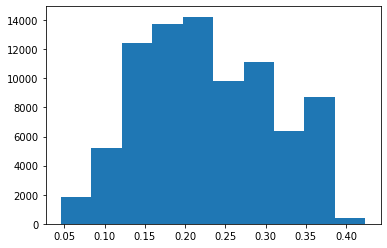

In [36]:
plt.hist(data=loan, x='BorrowerAPR');

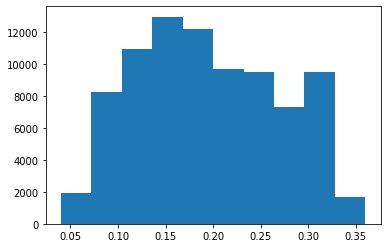

In [37]:
plt.hist(data=loan, x='BorrowerRate');

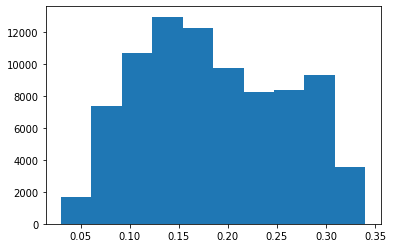

In [38]:
plt.hist(data=loan, x='LenderYield');

The variables above, BorrowerRate, BorrowerAPR and LenderYield have all values distribuited between 0.05 and 0.40, it look's a good data to take a look at the bivariate analysis. The three of them have a distribution very similar.

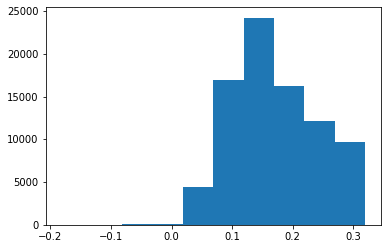

In [39]:
plt.hist(data=loan, x='EstimatedEffectiveYield');

There are some negative values, that I understand as a non profitable loan.

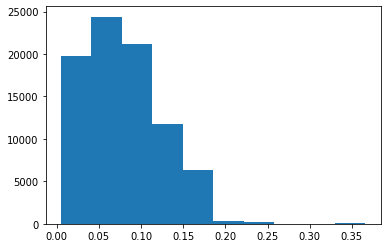

In [40]:
plt.hist(data=loan, x='EstimatedLoss');

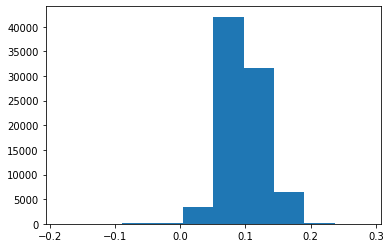

In [41]:
plt.hist(data=loan, x='EstimatedReturn');

The Estimated Loss is right skewed, so it's expected that most of the losses are around 5%. However, there are some values aorund 25% and 35%. The Estimate Return is concentrated arount 10% of the investment.

---
#### Support Features

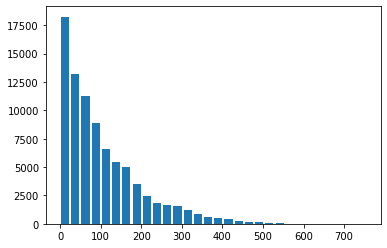

In [42]:
plt.hist(data=loan, x='EmploymentStatusDuration', bins=30, rwidth=0.8);

Most of the borrowers had a employment duration of 25 months when opening the listing. In the next steps, I will try to see if the borrowers with more years of work have bigger or smaller invest rates for their loans.

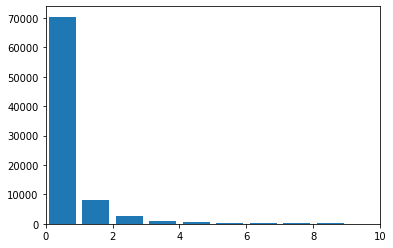

In [43]:
bins = np.arange(0, loan.CurrentDelinquencies.max()+1, 1)
plt.hist(data=loan, x='CurrentDelinquencies', bins=bins, rwidth=0.8);
plt.xlim((0,10));

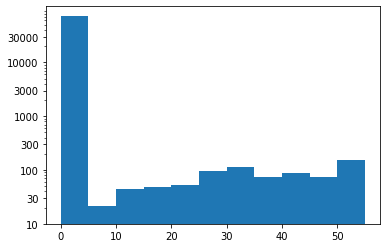

In [44]:
bins = np.arange(0, loan.CurrentDelinquencies.max()+5, 5)
plt.hist(data=loan, x='AmountDelinquent', bins=bins);

yticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
ylabels = [f'{y}' for y in yticks]
plt.yscale('log')
plt.yticks(yticks, ylabels);

Besides most of the delinquencies are between 0 and 10, there are a considerable number of it spread between 10 and 50.

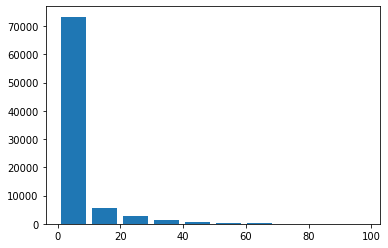

In [45]:
plt.hist(data=loan, x='DelinquenciesLast7Years', rwidth=0.8);

This three variables `CurrentDelinquencies`, `AmountDelinquent`, `DelinquenciesLast7Years` are representation of the same domain `Delinquency`. I will check their correlations with one of the main variables to understand if I need to use the three of them.

In [46]:
loan[['BorrowerAPR', 'EstimatedReturn',
      'CurrentDelinquencies', 'AmountDelinquent', 'DelinquenciesLast7Years']].corr()

,BorrowerAPR,EstimatedReturn,CurrentDelinquencies,AmountDelinquent,DelinquenciesLast7Years
BorrowerAPR,1.000000,0.793796,0.153887,0.054782,0.147157
EstimatedReturn,0.793796,1.000000,0.101875,0.038268,0.094337
CurrentDelinquencies,0.153887,0.101875,1.000000,0.353358,0.304152
AmountDelinquent,0.054782,0.038268,0.353358,1.000000,0.221654
DelinquenciesLast7Years,0.147157,0.094337,0.304152,0.221654,1.000000


This plot shows that there are weak correlation among BorrowerAPR, Estimated Return and delinquencys, so I will use only CurrentDelinquencies, which is the stronger one, to follow the analysis.

As just a some borrowers have delinquencies, I will create a feature to represent if the borrower has or has not a delinquency.

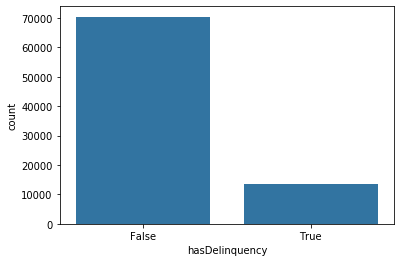

In [47]:
# creating hasDelinquency
loan['hasDelinquency'] = False
delinquent_indices = loan[loan['CurrentDelinquencies'] > 0].index
loan.loc[delinquent_indices, 'hasDelinquency'] = True

# plotting hasDelinquency
base_color = sb.color_palette()[0]
home_index = loan['hasDelinquency'].value_counts().index
sb.countplot(data=loan, x='hasDelinquency', order=home_index, color=base_color);

In [48]:
loan[['BorrowerAPR', 'EstimatedReturn', 'hasDelinquency']].corr()

,BorrowerAPR,EstimatedReturn,hasDelinquency
BorrowerAPR,1.000000,0.793796,0.191605
EstimatedReturn,0.793796,1.000000,0.134231
hasDelinquency,0.191605,0.134231,1.000000


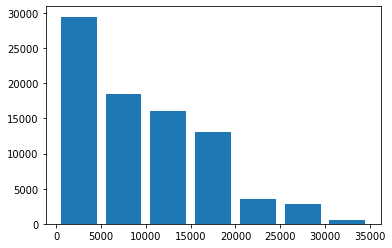

In [49]:
bins = np.arange(0, loan.LoanOriginalAmount.max()+5000, 5000)
plt.hist(data=loan, x='LoanOriginalAmount', bins=bins, rwidth=0.8);

The distribution of the loan amounts is right skewed. Many loans are smaller than 5 thousand dollars. Does any of the main features change because of the loan amount?

### Qualitative Variables
#### Support Features

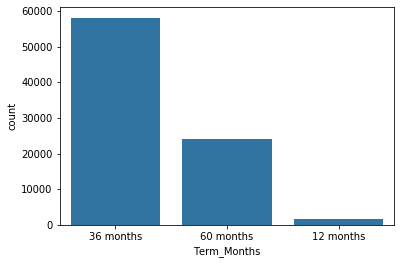

In [50]:
base_color = sb.color_palette()[0]
rating_index = loan['Term_Months'].value_counts().index
sb.countplot(data=loan, x='Term_Months', order=rating_index, color=base_color);

Approximately, half of the loans have a 36 months duration.

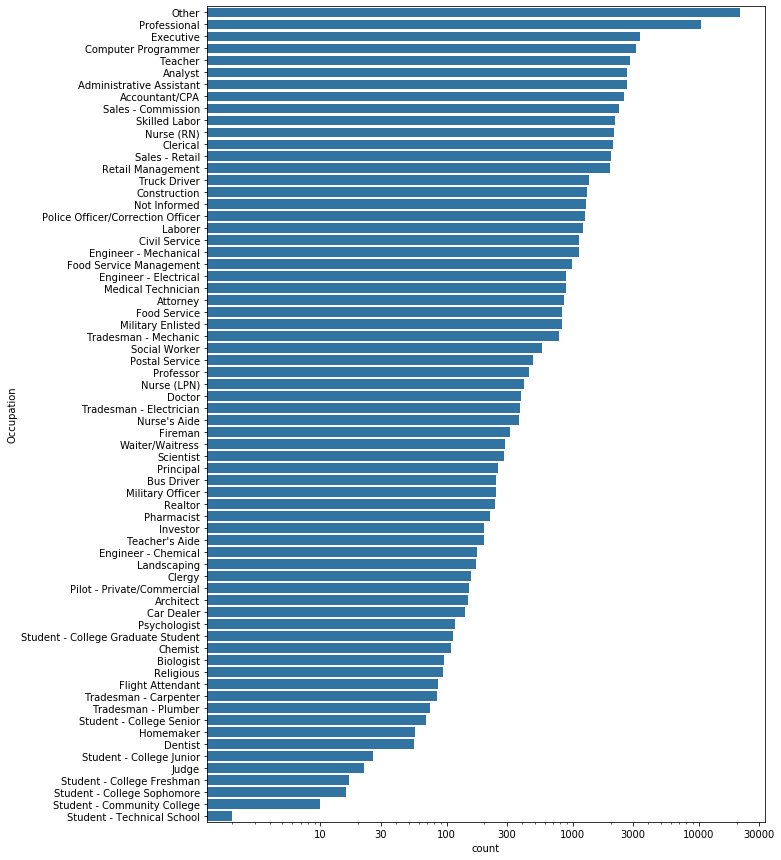

In [51]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(10, 15))
occup_index = loan['Occupation'].value_counts().index
sb.countplot(data=loan, y='Occupation', order=occup_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

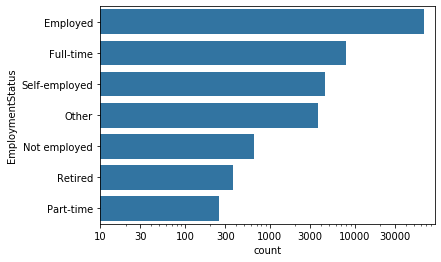

In [52]:
base_color = sb.color_palette()[0]
empl_index = loan['EmploymentStatus'].value_counts().index
sb.countplot(data=loan, y='EmploymentStatus', order=empl_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

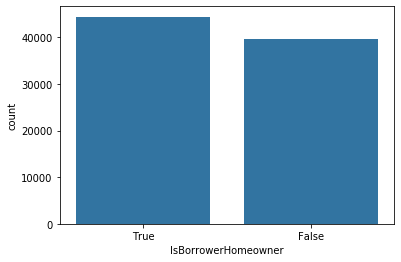

In [53]:
base_color = sb.color_palette()[0]
home_index = loan['IsBorrowerHomeowner'].value_counts().index
sb.countplot(data=loan, x='IsBorrowerHomeowner', order=home_index, color=base_color);

There are 3 main qualitative features related to the borrower: the occupation, the employment status, and if the borrower is a home owner. I would expect that this three things are related to the borrower rate, APR, and the estimated return. It will be checked in the bivariate and multivariate analysis.

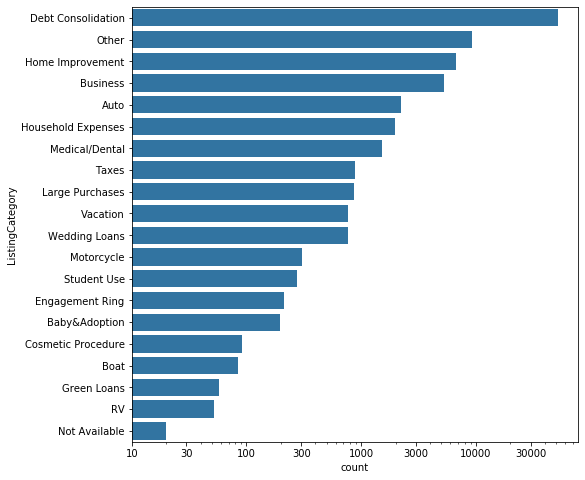

In [54]:
base_color = sb.color_palette()[0]
plt.figure(figsize=(8,8))
categories_index = loan['ListingCategory'].value_counts().index
sb.countplot(data=loan, y='ListingCategory', order=categories_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

There are different kinds of listing categories, it may imply in different rates for the loans.

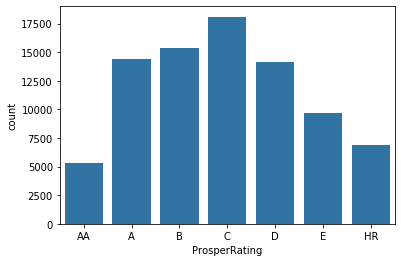

In [55]:
base_color = sb.color_palette()[0]
rating_index = ['AA', 'A', 'B', 'C', 'D', 'E', 'HR']
sb.countplot(data=loan, x='ProsperRating', order=rating_index, color=base_color);

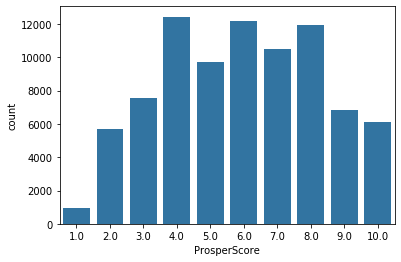

In [56]:
base_color = sb.color_palette()[0]
sb.countplot(data=loan, x='ProsperScore', color=base_color);

The Prosper Rating and Prosper Score are about the risk of the loan. AA and a 10 score refers to the lowest risks.

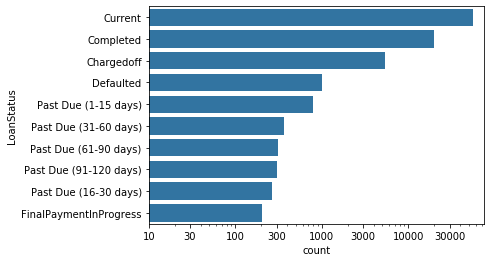

In [57]:
base_color = sb.color_palette()[0]
status_index = loan['LoanStatus'].value_counts().index
sb.countplot(data=loan, y='LoanStatus', order=status_index, color=base_color);
xticks = [10, 30, 100, 300, 1000, 3000, 10000, 30000]
xlabels = [f'{x}' for x in xticks]
plt.xscale('log')
plt.xticks(xticks, xlabels);

Overall there are more good payers than people with delinquencies. Most of the loans have status = `Current` or `completed`, which is really good.

## Bivariate Exploration

#### Quantitative and Quantitative

Firstly, I will check how BorrowerRate and BorrowerAPR are correlated to the other features.

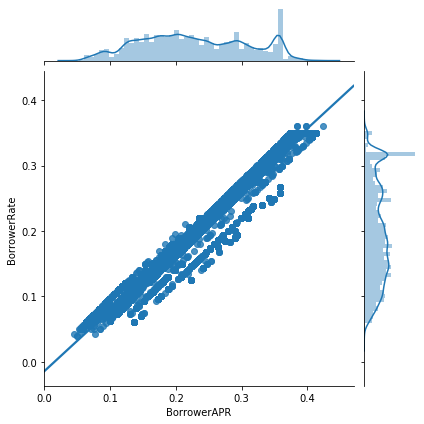

In [58]:
sb.jointplot(x='BorrowerAPR', y='BorrowerRate', data=loan, kind='reg');

Since they are very similar, I will use the BorrowerAPR to this analysis. Searching a little, I saw [(here)](https://www.bankrate.com/finance/mortgages/apr-and-interest-rate.aspx) that the APR includes the interest rate and other fees.

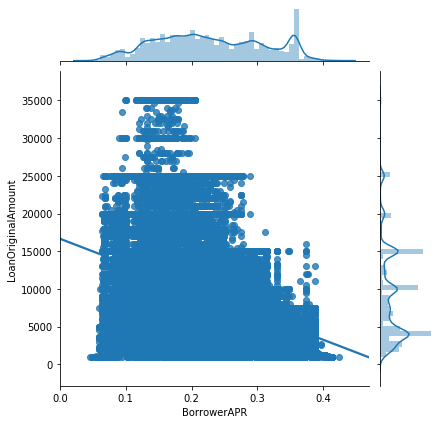

In [59]:
sb.jointplot(x='BorrowerAPR', y='LoanOriginalAmount', data=loan, kind='reg');

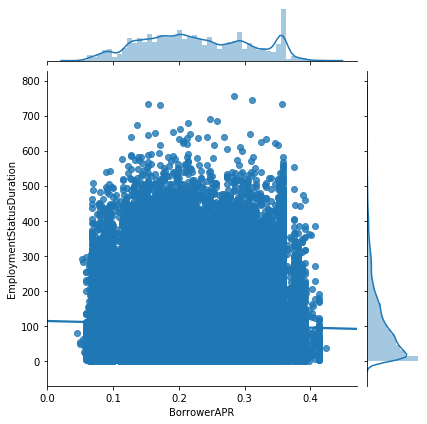

In [60]:
sb.jointplot(x='BorrowerAPR', y='EmploymentStatusDuration', data=loan, kind='reg');

This plot shows an interesting idea, we can see that the highest interest rates are not related to the biggest amounts of money. It probably happens because there's some other feature(s) that I'm not seeing now that impact it. 

The employment duration doesn't give me any insight, since the data is really spread in the chart.

---

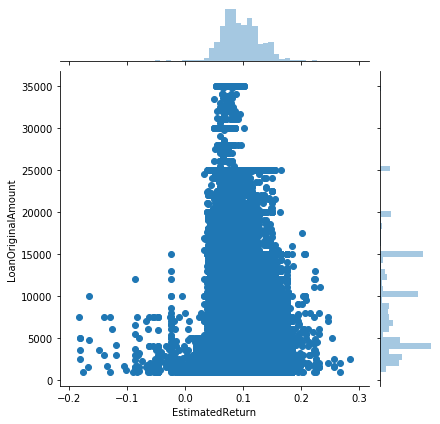

In [61]:
sb.jointplot(x='EstimatedReturn', y='LoanOriginalAmount', data=loan, kind='scatter');

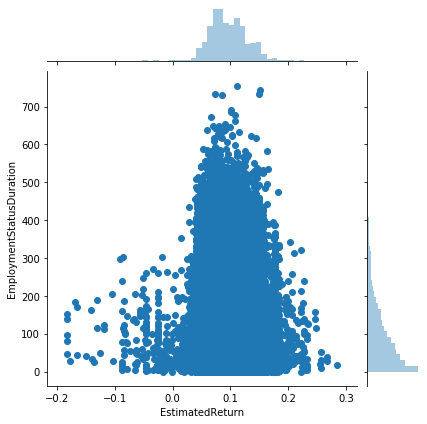

In [62]:
sb.jointplot(x='EstimatedReturn', y='EmploymentStatusDuration', data=loan, kind='scatter');

The EstimatedReturn has more variance as the LoanOriginalAmount decreases.

The less is the duration of employment the higher is the estimated return variance.

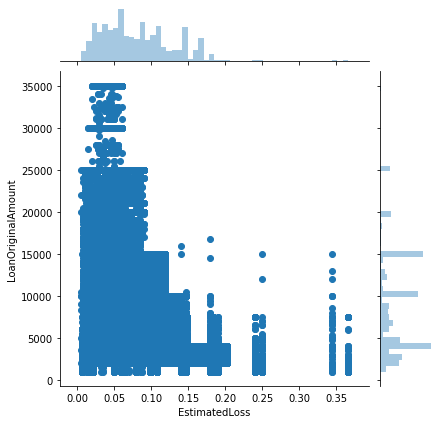

In [63]:
sb.jointplot(x='EstimatedLoss', y='LoanOriginalAmount', data=loan, kind='scatter');

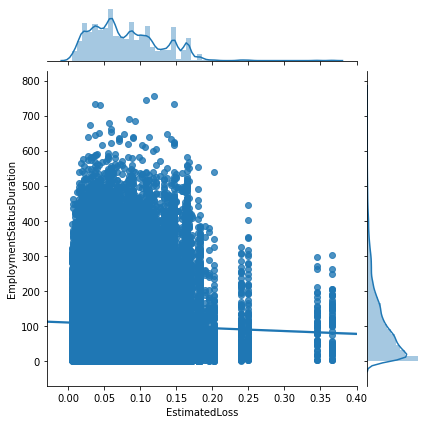

In [64]:
sb.jointplot(x='EstimatedLoss', y='EmploymentStatusDuration', data=loan, kind='reg');

Loans with bigger amount have smaller EstimatedLoss rate. My hipothesis is that people that ask for lesser amounts have more money issues than those who are asking for more.

Employment duration is concentrated in a few months (less than 50), however there are different estimated loss rates cross many months, so it not seem to have a strong relation between this two features.

In [65]:
loan[['EstimatedLoss', 'LoanOriginalAmount', 'EmploymentStatusDuration']].corr()

,EstimatedLoss,LoanOriginalAmount,EmploymentStatusDuration
EstimatedLoss,1.000000,-0.430436,-0.039134
LoanOriginalAmount,-0.430436,1.000000,0.078303
EmploymentStatusDuration,-0.039134,0.078303,1.000000


#### Quantitative and Qualitative

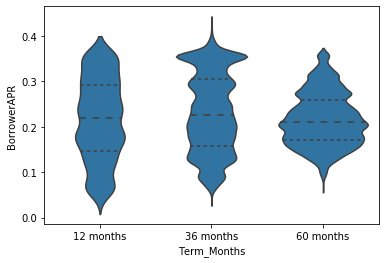

In [66]:
terms = ['12 months', '36 months', '60 months']
terms = pd.api.types.CategoricalDtype(ordered=True, categories=terms)
loan['Term_Months'] = loan['Term_Months'].astype(terms)

sb.violinplot(data=loan, x='Term_Months', y='BorrowerAPR', inner='quartile', color=base_color);

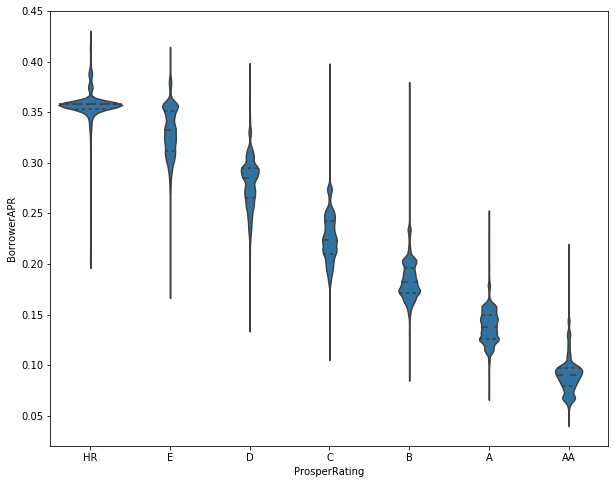

In [67]:
ratings = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
ratings = pd.api.types.CategoricalDtype(ordered=True, categories=ratings)
loan['ProsperRating'] = loan['ProsperRating'].astype(ratings)

plt.figure(figsize=(10,8))
sb.violinplot(data=loan, y='BorrowerAPR', x='ProsperRating', inner='quartile', color=base_color);

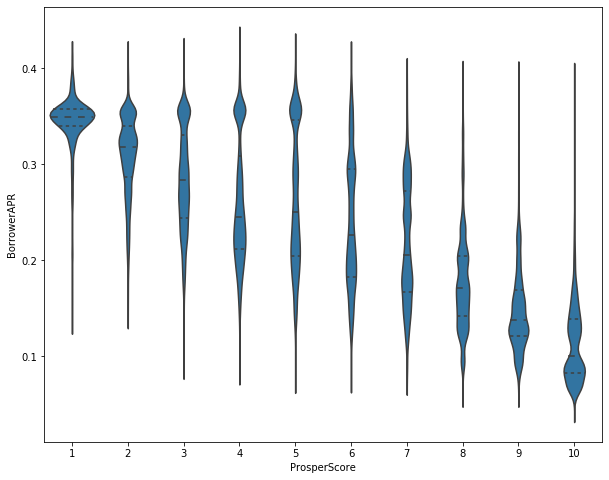

In [68]:
scores = range(1, 11, 1)
scores = pd.api.types.CategoricalDtype(ordered=True, categories=scores)
loan['ProsperScore'] = loan['ProsperScore'].astype(scores)

plt.figure(figsize=(10,8))
sb.violinplot(data=loan, y='BorrowerAPR', x='ProsperScore', inner='quartile', color=base_color);

The three features above, have a good relationship with the BorrowerAPR.

The 60 months term is the one with the most concentrated data for APR. For the other two, the data is a bit more spread.

The ProsperRating is very correlated. As the risk decreases, the APR does it too. The ProsperScore has a very similar behavior, so in the furter steps I will use only the ProsperRating.

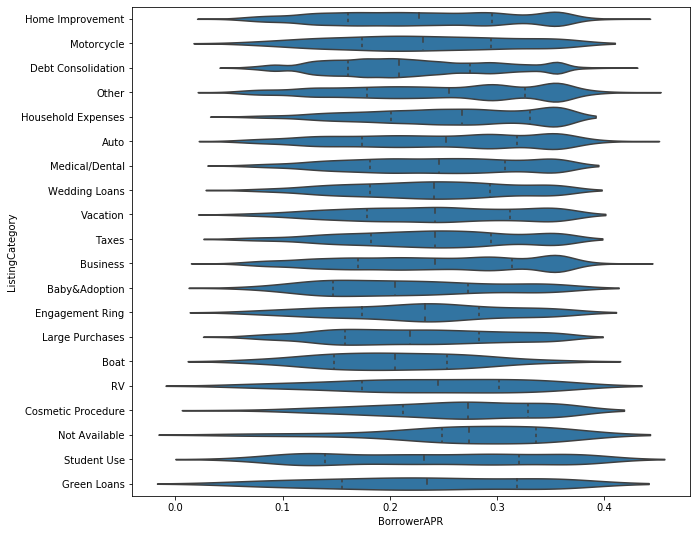

In [69]:
categs = list(loan.ListingCategory.unique())
categs = pd.api.types.CategoricalDtype(ordered=True, categories=categs)
loan['ListingCategory'] = loan['ListingCategory'].astype(categs)

plt.figure(figsize=(10,9))
sb.violinplot(data=loan, x='BorrowerAPR', y='ListingCategory', inner='quartile', color=base_color);

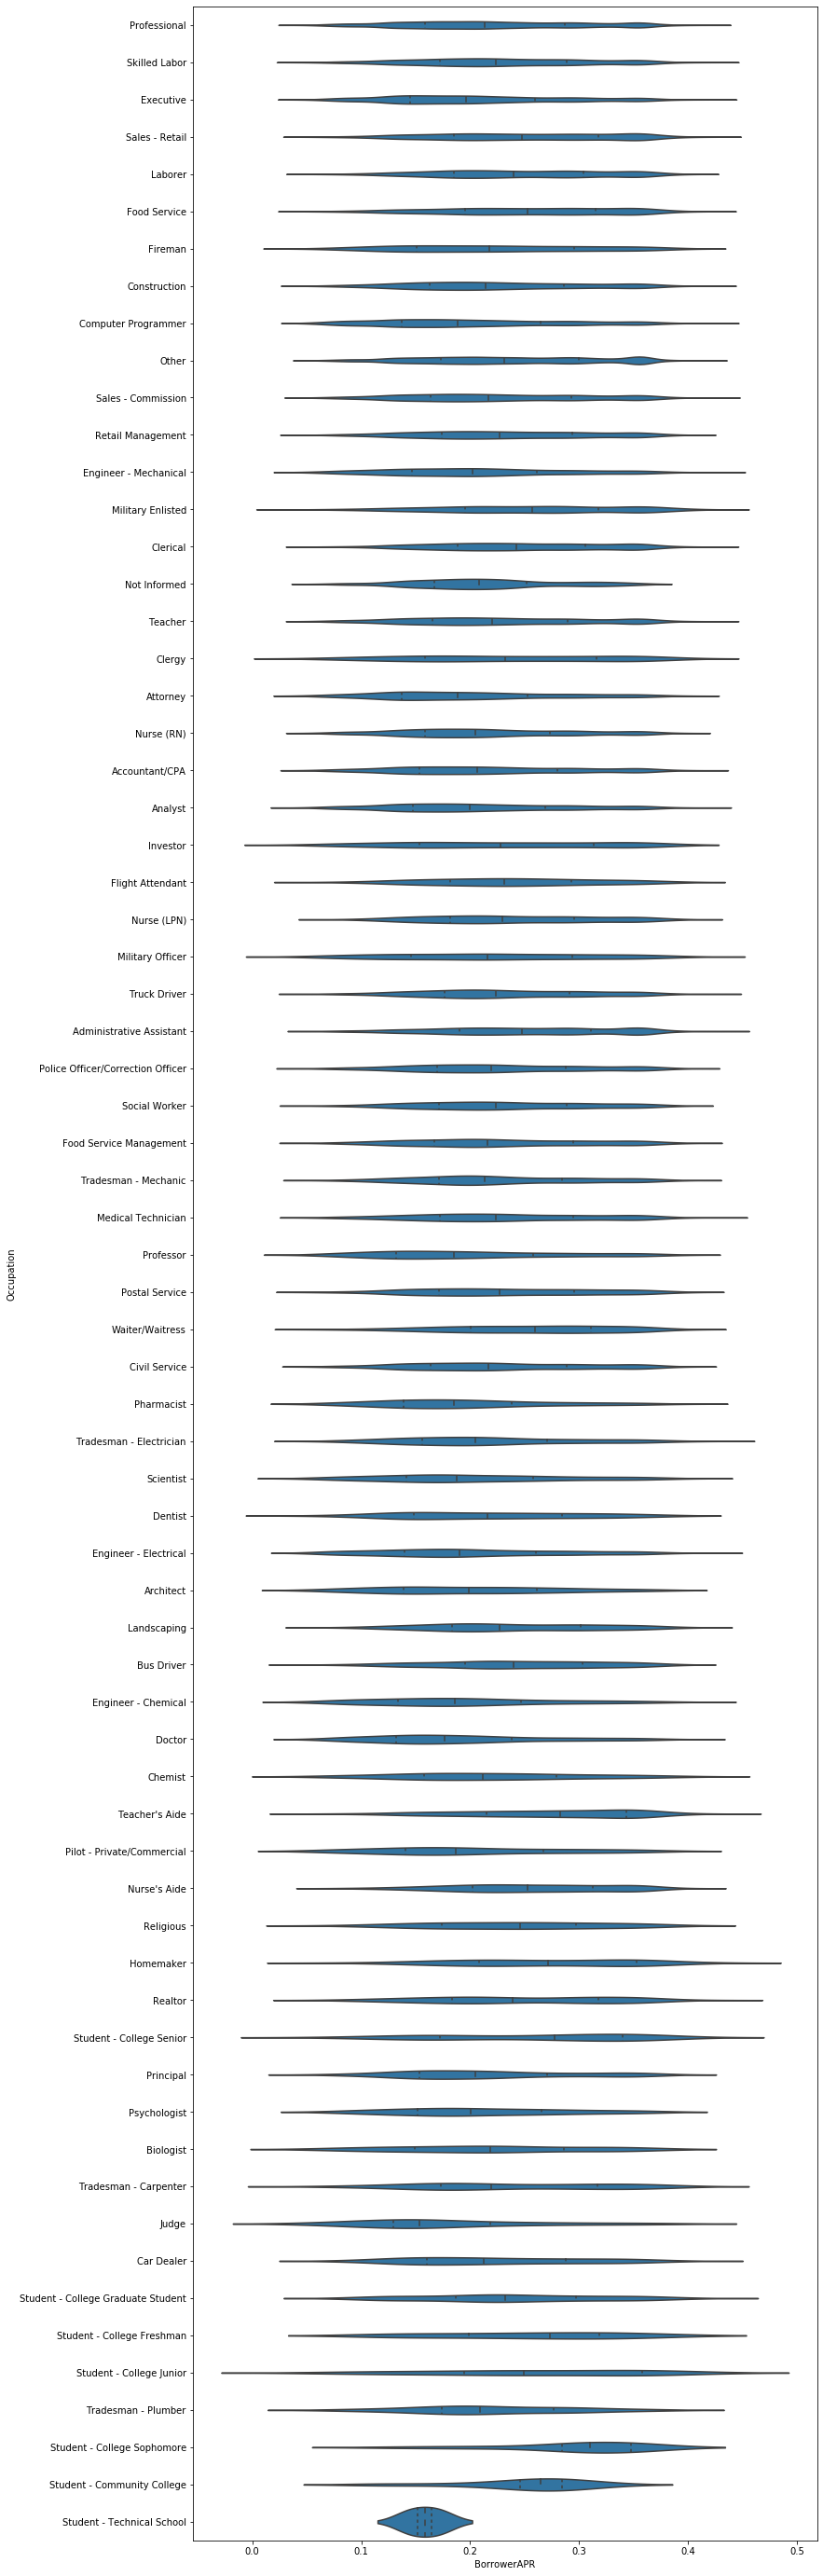

In [70]:
occup = list(loan.Occupation.unique())
occup = pd.api.types.CategoricalDtype(ordered=True, categories=occup)
loan['Occupation'] = loan['Occupation'].astype(occup)

plt.figure(figsize=(12,50))
sb.violinplot(data=loan, x='BorrowerAPR', y='Occupation', inner='quartile', color=base_color);

The listings' categories do not seem to have a string correlation with the borrower APR.

Almost every occupation have a data very spread among the borrower rate, the only one that are different are the student's one. For this reason I will not use this feature anymore.

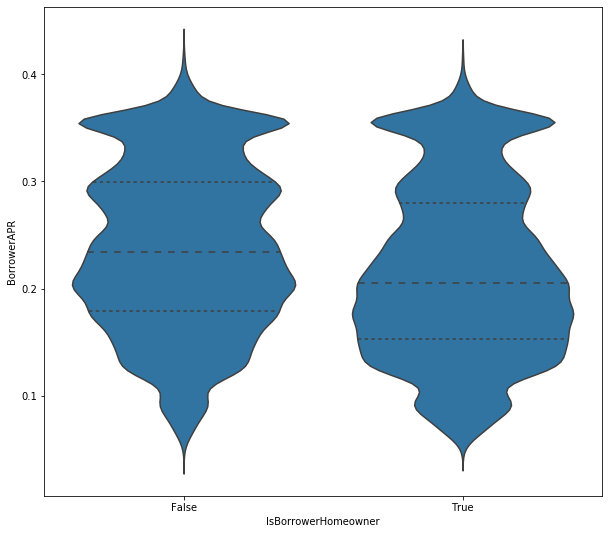

In [71]:
homeowner = list(loan.IsBorrowerHomeowner.unique())
homeowner = pd.api.types.CategoricalDtype(ordered=True, categories=homeowner)
loan['IsBorrowerHomeowner'] = loan['IsBorrowerHomeowner'].astype(homeowner)

plt.figure(figsize=(10,9))
sb.violinplot(data=loan, y='BorrowerAPR', x='IsBorrowerHomeowner', inner='quartile', color=base_color);

Both violin plots are very similar. This feature alone doesn't seem to be a good one to have insights.

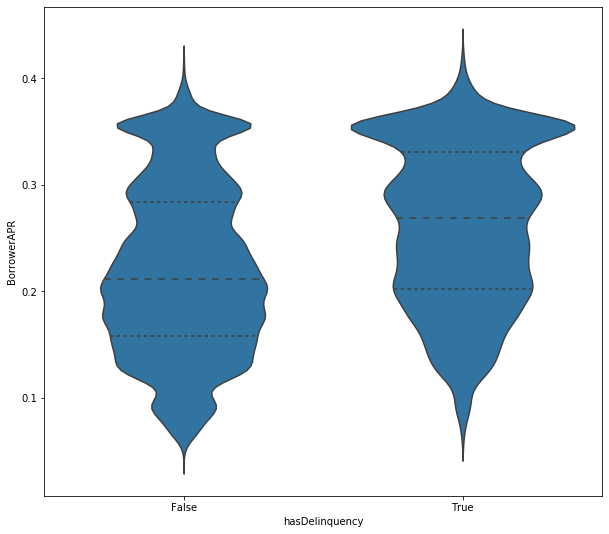

In [72]:
delinquency = list(loan.hasDelinquency.unique())
delinquency = pd.api.types.CategoricalDtype(ordered=True, categories=delinquency)
loan['hasDelinquency'] = loan['hasDelinquency'].astype(delinquency)

plt.figure(figsize=(10,9))
sb.violinplot(data=loan, y='BorrowerAPR', x='hasDelinquency', inner='quartile', color=base_color);

When borrower has delinquency the APR tends to be higher than when the borrower doesn't have delinquencies.

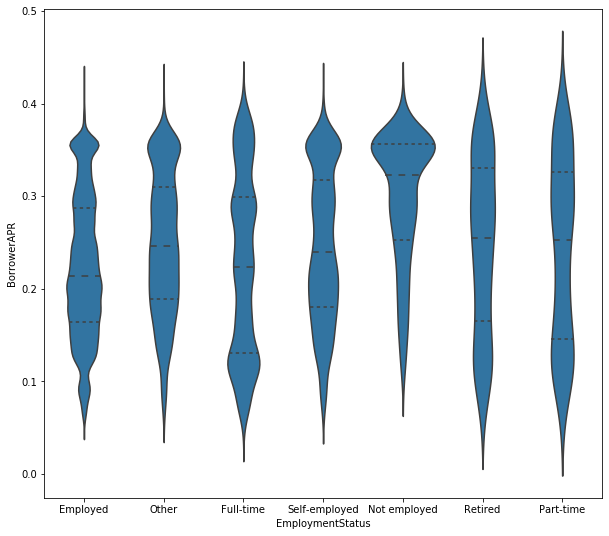

In [73]:
empl_status = list(loan.EmploymentStatus.unique())
empl_status = pd.api.types.CategoricalDtype(ordered=True, categories=empl_status)
loan['EmploymentStatus'] = loan['EmploymentStatus'].astype(empl_status)

plt.figure(figsize=(10,9))
sb.violinplot(data=loan, y='BorrowerAPR', x='EmploymentStatus', inner='quartile', color=base_color);

Overall this data is not so good to bring some accurate insight. I will use it in the multivariate plots hoping that it gets me some idea. At this point, I only can see that `Not employed` have the worst rates, while full-time status tend to have the lowest rates.

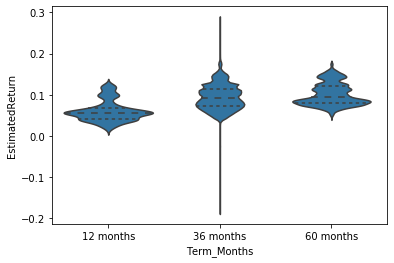

In [74]:
terms = ['12 months', '36 months', '60 months']
terms = pd.api.types.CategoricalDtype(ordered=True, categories=terms)
loan['Term_Months'] = loan['Term_Months'].astype(terms)

sb.violinplot(data=loan, x='Term_Months', y='EstimatedReturn', inner='quartile', color=base_color);

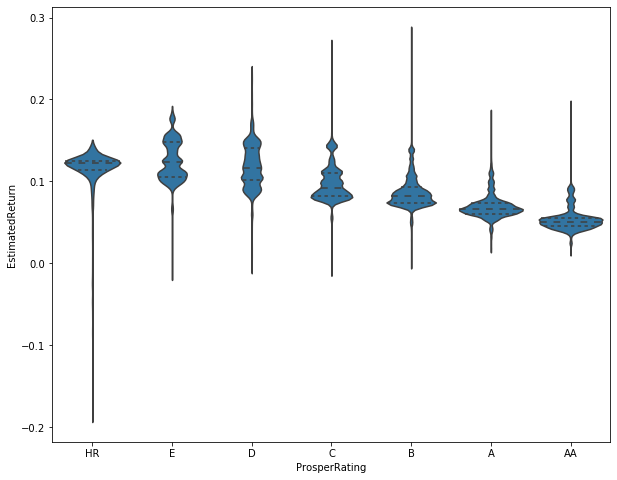

In [75]:
ratings = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
ratings = pd.api.types.CategoricalDtype(ordered=True, categories=ratings)
loan['ProsperRating'] = loan['ProsperRating'].astype(ratings)

plt.figure(figsize=(10,8))
sb.violinplot(data=loan, y='EstimatedReturn', x='ProsperRating', inner='quartile', color=base_color);

The greater is the `Term`, the bigger is the `EstimatedReturn`.

Also, loans with less risk (AA rating) have lower EstimatedReturn.

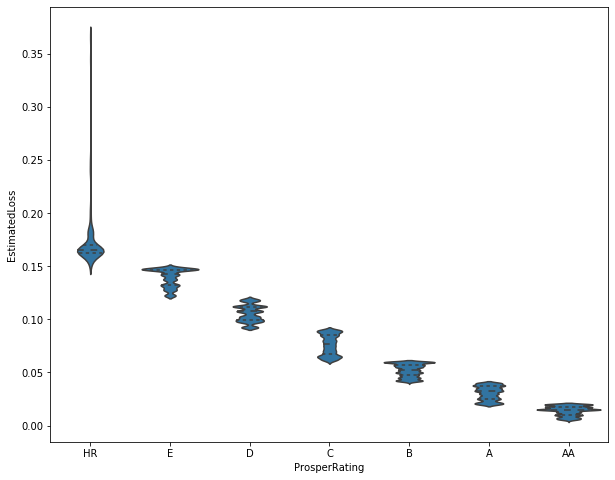

In [76]:
ratings = ['HR', 'E', 'D', 'C', 'B', 'A', 'AA']
ratings = pd.api.types.CategoricalDtype(ordered=True, categories=ratings)
loan['ProsperRating'] = loan['ProsperRating'].astype(ratings)

plt.figure(figsize=(10,8))
sb.violinplot(data=loan, y='EstimatedLoss', x='ProsperRating', inner='quartile', color=base_color);

As I expected, ProsperRating also defines very well the EstimatedLoss.

#### Qualitative and Qualitative

As I saw previously that ProsperRating is a variable that has good correlation with the main features, I will plot it against the qualitative variables that relates to the borrower to see if there is some insight.

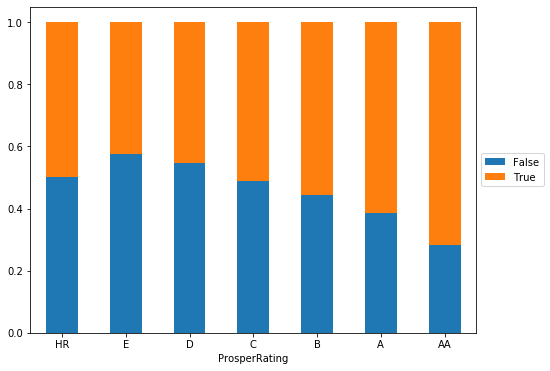

In [77]:
props = loan.groupby('ProsperRating')['IsBorrowerHomeowner'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked=True, figsize=(8,6), rot=0);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

This plot shows that better risk categories have more homeowners. In the category AA, around 1/3 of the borrowers have a house, while in category HR it's just half.

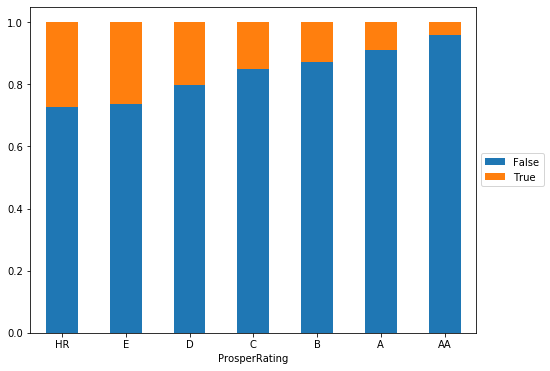

In [78]:
props = loan.groupby('ProsperRating')['hasDelinquency'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked=True, figsize=(8,6), rot=0);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

This graph illustrates that better risk categories have less delinquent borrowers. In the category AA, only 5% of the borrowers have delinquencies, while in category HR around 25% are delinquent.

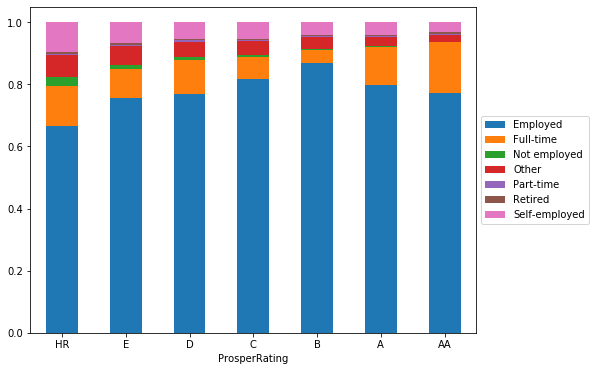

In [79]:
props = loan.groupby('ProsperRating')['EmploymentStatus'].value_counts(normalize=True).unstack()
props.plot(kind='bar', stacked=True, figsize=(8,6), rot=0);
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Borrowers that are self-employed, have loans with more risk, while loans with less risk have more full time and employed borrowers.

## Multivariate Exploration

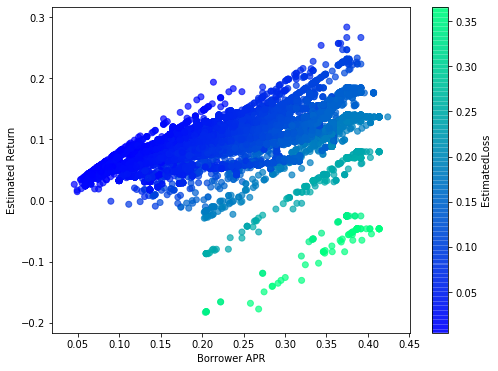

In [80]:
plt.figure(figsize = [8,6])
plt.scatter(data=loan, x='BorrowerAPR', y='EstimatedReturn', c='EstimatedLoss', alpha=0.7, cmap='winter')
plt.colorbar(label='EstimatedLoss')
plt.xlabel('Borrower APR');
plt.ylabel('Estimated Return');

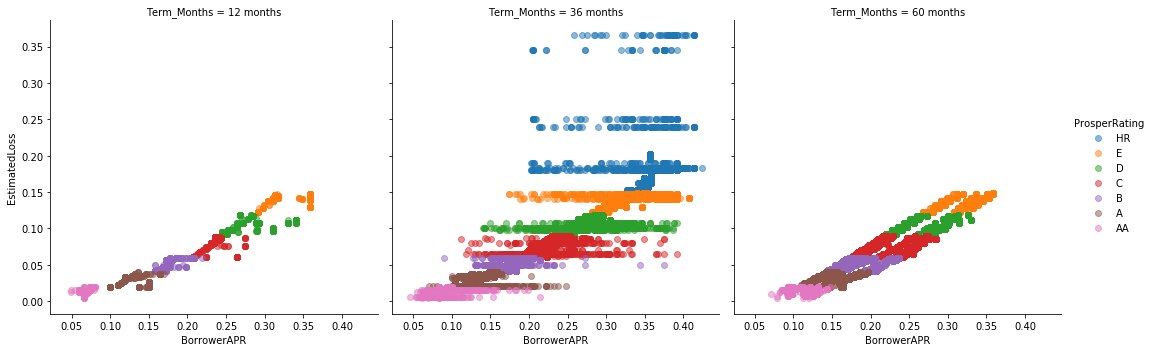

In [250]:
g = sb.FacetGrid(data=loan, hue='ProsperRating', size=5, col='Term_Months', col_wrap=3);
g.map(plt.scatter, 'BorrowerAPR', 'EstimatedLoss', alpha=0.5);
g.add_legend();

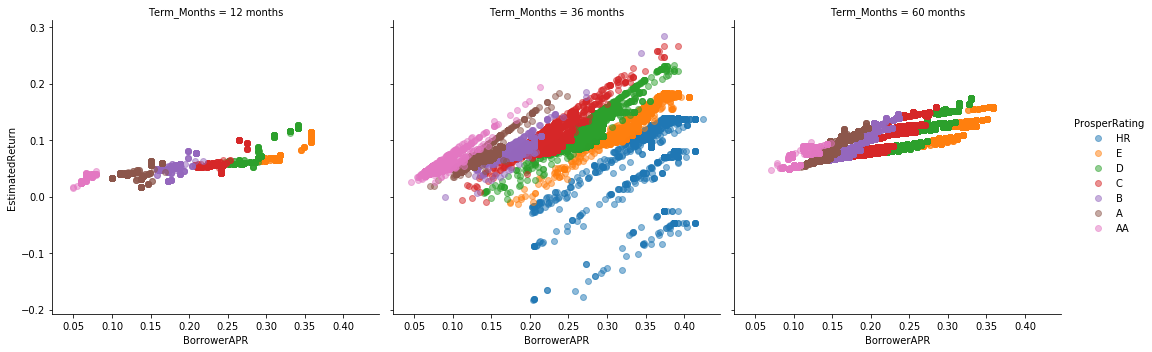

In [251]:
g = sb.FacetGrid(data=loan, hue='ProsperRating', size=5, col='Term_Months', col_wrap=3);
g.map(plt.scatter, 'BorrowerAPR', 'EstimatedReturn', alpha=0.5);
g.add_legend();

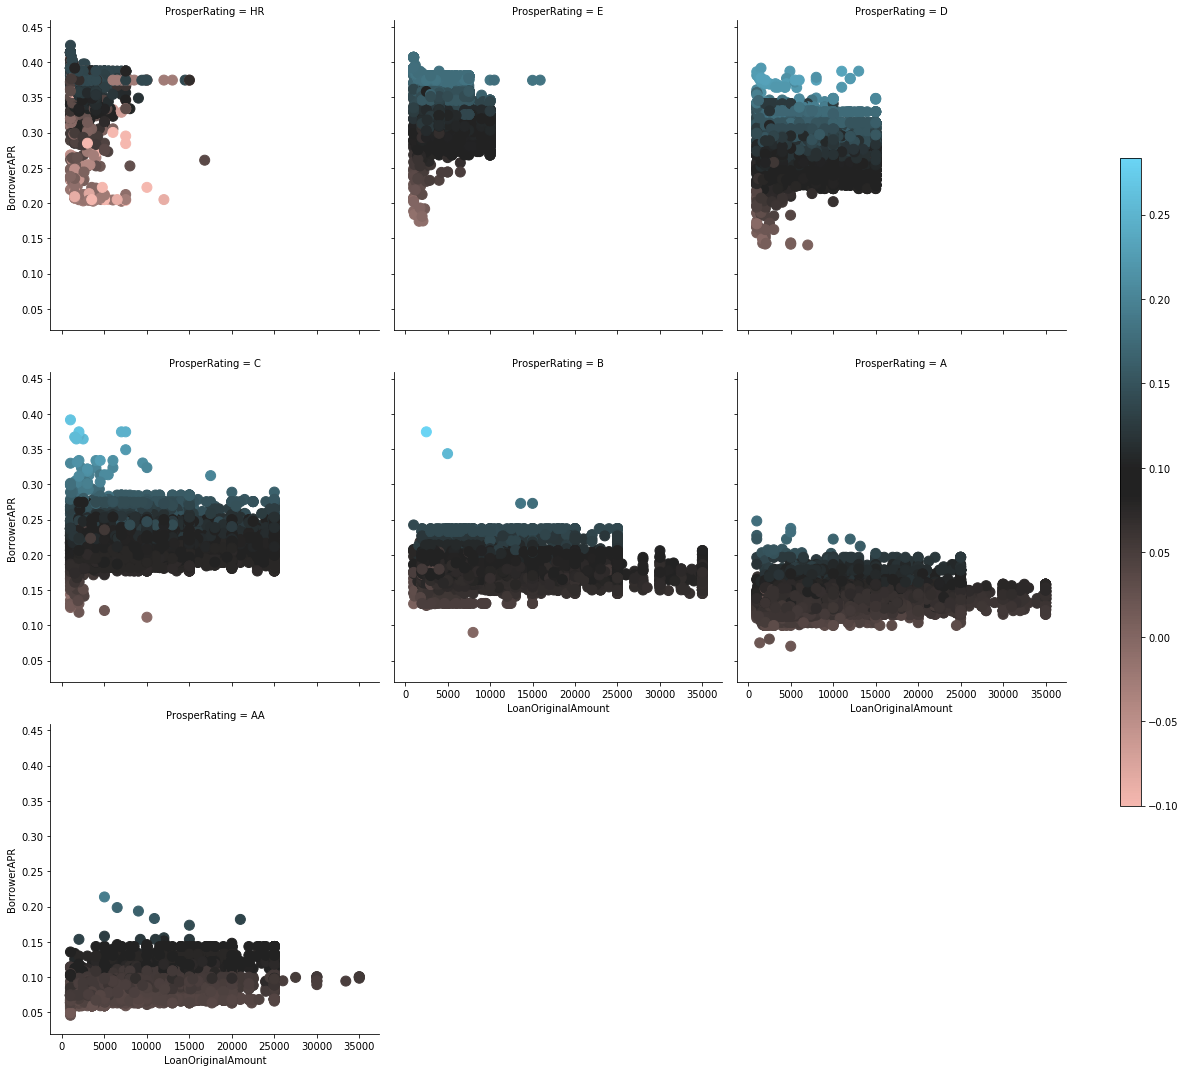

In [255]:
def scatter_plot(x, y, c, **kwargs):
    kwargs.pop('color')
    plt.scatter(x, y, c=c, **kwargs)
    
vmin, vmax = -0.1, loan.EstimatedReturn.max()
cmap = sb.diverging_palette(20, 220, n=7, s=80, l=80, as_cmap=True, center='dark')

g = sb.FacetGrid(data=loan, col='ProsperRating', size=5, col_wrap=3)
g.map(scatter_plot, 'LoanOriginalAmount', 'BorrowerAPR', 'EstimatedReturn',
      s=100, alpha=1, vmin=vmin, vmax=vmax, cmap=cmap);
cax = g.fig.add_axes([1.04, .25, .02, .6])

# Get a mappable object with the same colormap as the data
points = plt.scatter([], [], c=[], vmin=vmin, vmax=vmax, cmap=cmap);

# Draw the colorbar
g.fig.colorbar(points, cax=cax);

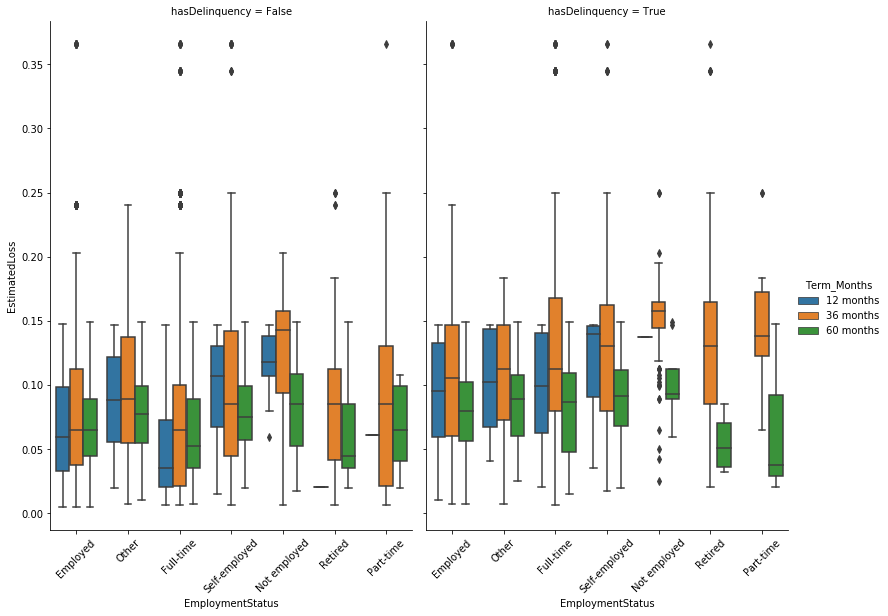

In [253]:
g = sb.catplot(data=loan, hue='Term_Months', y='EstimatedLoss', col='hasDelinquency', x='EmploymentStatus',
               kind='box', height=8, aspect=0.7, col_wrap=2)
g.set_xticklabels(rotation=45);

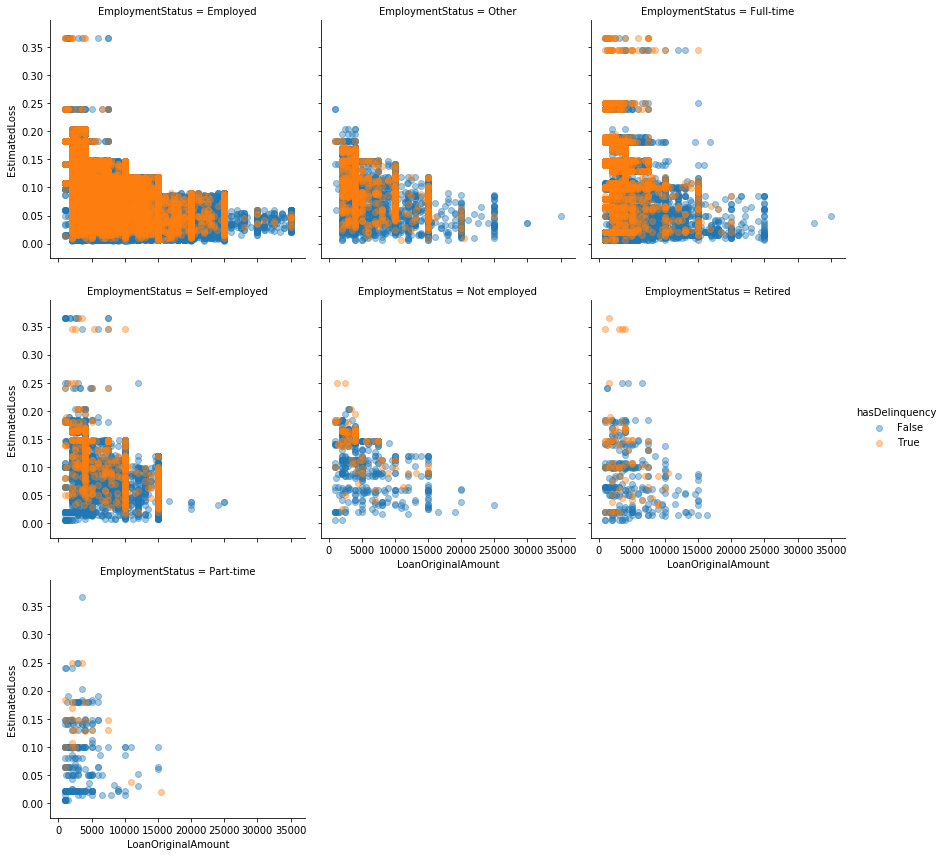

In [137]:
plt.figure
g = sb.FacetGrid(data=loan, col='EmploymentStatus', hue='hasDelinquency', size=4, col_wrap=3)
g.map(plt.scatter, 'LoanOriginalAmount', 'EstimatedLoss', alpha=0.4);
g.add_legend();

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> Your answer here!

### Were there any interesting or surprising interactions between features?

> Your answer here!

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!